In [367]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from project_code.preprocessor import split_data
import pickle

In [368]:

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

#### importing and loading data

In [4]:
%cd ..

/Users/Marie/code/MarieMCodes/re_value_predictor


/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [369]:
data=pd.read_csv('raw_data/london_re_postcodes_latlon_master.zip',
                    dtype={'price': np.int32,'month':np.int8,'year':np.int16},
                    ).sample(300000)
    # master: drop month, drop date
data.drop(columns=['date','month'],inplace=True)

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 408495 to 1061438
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   price          100000 non-null  int32  
 1   property_type  100000 non-null  object 
 2   property_age   100000 non-null  object 
 3   ownership      100000 non-null  object 
 4   year           100000 non-null  int16  
 5   lat            100000 non-null  float64
 6   lon            100000 non-null  float64
 7   sin_time       100000 non-null  float64
 8   cos_time       100000 non-null  float64
dtypes: float64(4), int16(1), int32(1), object(3)
memory usage: 6.7+ MB


In [370]:
# remove premium price outliers and too low house prices
data_concise=data[(data['price']<1500000) & (data['price']>299000)]

### Visualising distribution of prices across London

(51.3, 51.7)

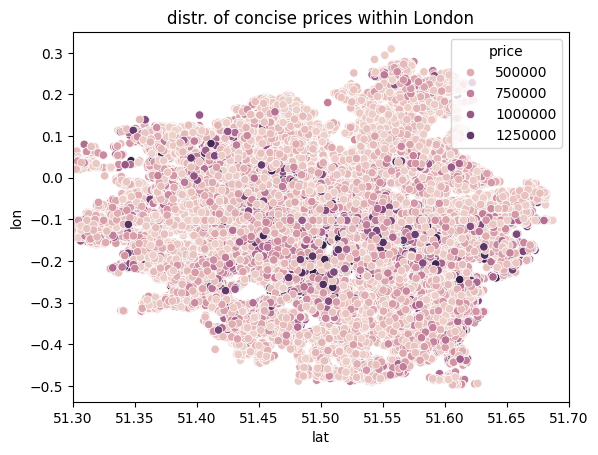

In [376]:

sns.scatterplot(x='lat',y='lon',data=data_concise,hue='price')
plt.title("distr. of concise prices within London")
plt.xlim(51.30,51.70)

(51.3, 51.7)

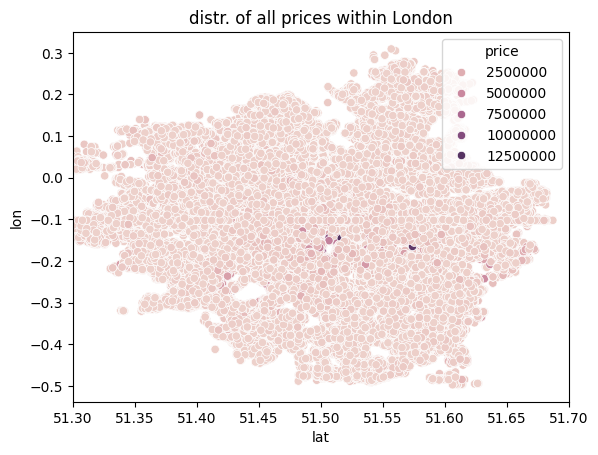

In [377]:
sns.scatterplot(x='lat',y='lon',data=data,hue='price')
plt.title("distr. of all prices within London")
plt.xlim(51.30,51.70)

(51.3, 51.7)

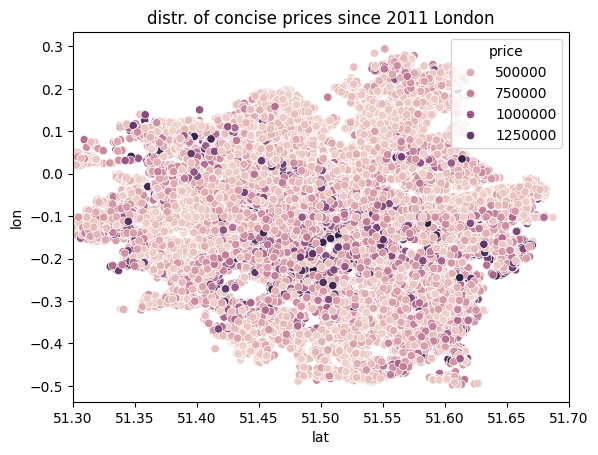

In [382]:
sns.scatterplot(x='lat',y='lon',data=data_concise[data_concise['year']>2010],hue='price')
plt.title("distr. of concise prices since 2011 London")
plt.xlim(51.30,51.70)

(51.3, 51.7)

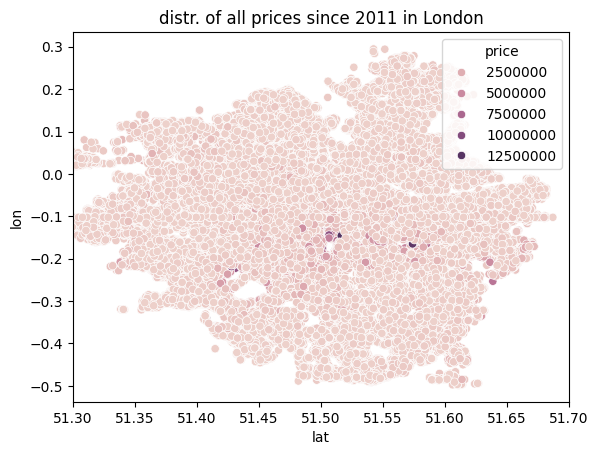

In [381]:
sns.scatterplot(x='lat',y='lon',data=data[data['year']>2010],hue='price')
plt.title("distr. of all prices since 2011 in London")
plt.xlim(51.30,51.70)

In [ ]:
#maybe add interactive map where slider is year and we see house prices develop - cumulatively? 

### Exploring data

In [158]:
# exploring prices and outliers in recent years
data[data['year']>2020].describe()

price          year           lat           lon      sin_time  \
count  3.165900e+04  31659.000000  31659.000000  31659.000000  3.165900e+04   
mean   6.916474e+05   2021.509492     51.498837     -0.115222  1.034899e-01   
std    6.851404e+05      0.606207      0.077155      0.153160  7.077638e-01   
min    2.000000e+05   2021.000000     51.293401     -0.498166 -1.000000e+00   
25%    3.850000e+05   2021.000000     51.443223     -0.210711 -5.000000e-01   
50%    5.157610e+05   2021.000000     51.499752     -0.116026  1.224647e-16   
75%    7.400000e+05   2022.000000     51.559608     -0.015721  8.660254e-01   
max    1.400000e+07   2023.000000     51.682136      0.325661  1.000000e+00   

           cos_time  
count  3.165900e+04  
mean  -6.448691e-02  
std    6.958684e-01  
min   -1.000000e+00  
25%   -8.660254e-01  
50%   -1.836970e-16  
75%    5.000000e-01  
max    1.000000e+00

In [146]:
data[(data['year']>2000) & (data['price']>8000000)].count()
# 10ml.
# 8 ml total 185 of which 54 in last 3 years
tmp=data[(data['year']>2010) & (data['price']<4000000)]
tmp.describe()

price           year            lat            lon  \
count  1.649550e+05  164955.000000  164955.000000  164955.000000   
mean   5.683910e+05    2016.735728      51.498947      -0.117016   
std    4.348375e+05       3.372800       0.075449       0.144391   
min    2.000000e+05    2011.000000      51.293401      -0.498166   
25%    3.218370e+05    2014.000000      51.445976      -0.203887   
50%    4.400000e+05    2017.000000      51.499302      -0.104839   
75%    6.399500e+05    2020.000000      51.556285      -0.025286   
max    3.999950e+06    2023.000000      51.685423       0.325661   

           sin_time      cos_time  
count  1.649550e+05  1.649550e+05  
mean  -2.274013e-02 -1.357393e-02  
std    7.089186e-01  7.047972e-01  
min   -1.000000e+00 -1.000000e+00  
25%   -8.660254e-01 -8.660254e-01  
50%   -2.449294e-16 -1.836970e-16  
75%    5.000000e-01  5.000000e-01  
max    1.000000e+00  1.000000e+00

In [152]:
len(data[data['price']<3500000])/len(data)

0.9945066666666666

In [331]:
len(data[(data['price']<1500000) & (data['price']>299000)])/len(data)

0.6202033333333333

(array([54641., 47976., 25304., 13261.,  7532.,  3722.,  3445.,  2026.,
         1455.,  1163.,   874.,   632.,   572.,   399.,   328.,   287.,
          259.,   258.,   193.,   152.,   166.,   107.,   117.,    86.]),
 array([ 200000.  ,  358331.25,  516662.5 ,  674993.75,  833325.  ,
         991656.25, 1149987.5 , 1308318.75, 1466650.  , 1624981.25,
        1783312.5 , 1941643.75, 2099975.  , 2258306.25, 2416637.5 ,
        2574968.75, 2733300.  , 2891631.25, 3049962.5 , 3208293.75,
        3366625.  , 3524956.25, 3683287.5 , 3841618.75, 3999950.  ]),
 <BarContainer object of 24 artists>)

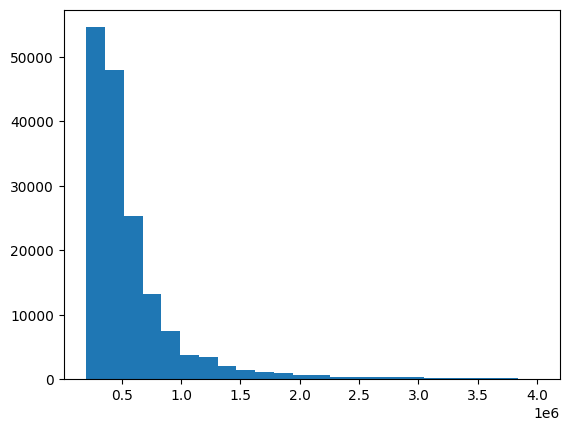

In [278]:
plt.hist(x=tmp['price'], bins=24)

In [272]:
# only keepig properties below 3.5 ml
data_clean=data[data['price']<3500000]
len(data_clean)

298352

In [273]:
X=data_clean.drop(columns='price')
y=data_clean['price']
y.shape

(298352,)

In [122]:
import matplotlib.pyplot as plt

In [113]:
data['property_type'].unique()

array(['F', 'T', 'S', 'D'], dtype=object)

### Preprocessing data

In [159]:
def preprocess_X(X):
    preprocessor=pickle.load(open("models/preprocessor_latlon.pkl","rb"))
    X_processed=preprocessor.transform(X)
    print(f"✅ new data processed with shape {X_processed.shape}")
    return X_processed

def process_y(y):
    y_processed=np.log(y)
    print(f"✅ y logged  with shape {y_processed.shape}")
    return y_processed


def split_x_y(X_processed,y_processed):
    # split the processed X and y
    X_train, X_test, y_train, y_test= split_data(X_processed,y_processed)
    return X_train, X_test, y_train, y_test


def process_and_split(X,y):
    X_processed=preprocess_X(X)
    y_processed=process_y(y)
    X_train, X_test, y_train, y_test=split_x_y(X_processed,y_processed)
    return X_train, X_test, y_train, y_test


In [62]:
!pwd

/Users/Marie/code/MarieMCodes/re_value_predictor


In [318]:
X_train, X_test, y_train, y_test=process_and_split(X,y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

✅ new data processed with shape (298352, 11)
✅ y logged  with shape (298352,)


((208846, 11), (89506, 11), (208846,), (89506,))

### Building model architecture -> into Pipeline

In [271]:
def initialize_model() -> Model:
    """
    Initialize the Neural Network with random weights
    """
    model = Sequential()
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))  # Output layer
    return model


def compile_model(model:Model, learning_rate: learning_rate, epochs: epochs, batch_size=32) -> tuple[Model, dict]:
    """
    compiles model
    """
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    print("✅ Model compiled")
    return model


def train_model(
        model: Model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        batch_size=64,
        patience=10,
        validation_data=None,
        validation_split=0.3
    ) -> tuple[Model, dict]:
    """
    trains model
    """
    print("starting model training")

    es = EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train,
        y_train,
        validation_data=validation_data,
        validation_split=validation_split,
        epochs=100,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    print(f"✅ Model trained on {len(X_train)} rows with min val MAE: {round(np.min(history.history['val_mae']), 2)}")

    return model, history




def evaluate_model(model: Model, X_test: np.ndarray, y_test: np.ndarray) -> tuple[float, float]:
    """
    evaluate trained model on test data
    """
    metrics = model.evaluate(X_test,
                             y_test,
                             batch_size=32,
                             return_dict=True
    )

    mse = metrics["loss"]
    mae = metrics["mae"]
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    return mae, mse


#### Second, tuned dnn model

In [317]:
#from tensorflow.keras.optimizers.schedules import ExponentialDecay

# learning rate starts higher at beg. and then decreases over time. 
#initial_learning_rate = 0.01
#lr_schedule = ExponentialDecay(
# Every 200 iterations, multiply the learning rate by 0.5
#initial_learning_rate, decay_steps = 200, decay_rate = 0.5
#)


# try alternative model 
def initialize_model_2() -> Model:
    """
    Initialize the Neural Network with random weights
    """
    model = Sequential()
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))  # Output layer
    return model


def compile_model_2(model:Model, learning_rate= 0.001, epochs= 100, batch_size=32) -> tuple[Model, dict]:
    """
    compiles model
    """
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    print("✅ Model compiled")
    return model


def train_model_2(
        model: Model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        batch_size=32,
        patience=10,
        validation_data=None,
        validation_split=0.3
    ) -> tuple[Model, dict]:
    """
    trains model
    """
    print("starting model training")

    es = EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train,
        y_train,
        validation_data=validation_data,
        validation_split=validation_split,
        epochs=100,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    print(f"✅ Model trained on {len(X_train)} rows with min val MAE: {round(np.min(history.history['val_mae']), 2)}")

    return model, history




def evaluate_model_2(model: Model, X_test: np.ndarray, y_test: np.ndarray) -> tuple[float, float]:
    """
    evaluate trained model on test data
    """
    metrics = model.evaluate(X_test,
                             y_test,
                             batch_size=32,
                             return_dict=True
    )

    mse = metrics["loss"]
    mae = metrics["mae"]
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    return mae, mse


### Running DNN models

#### Run model DNN - full

In [165]:
# initialise_model
model=initialize_model()

# compile_model
model=compile_model(model,learning_rate=0.001, epochs=80 )

# train_model
model,history=train_model(model,X_train,y_train)
print('✅ model finished training')

#save model
#save_model(model, '../models/model_latlon_full.h5')
#print('✅ model saved ')

# evaluate
mae, mse=evaluate_model(model,X_test,y_test)
print(f'MAE is {mae}, and MSE is {mse}. Training is complete')

✅ Model compiled
starting model training
Restoring model weights from the end of the best epoch: 44.
Epoch 54: early stopping
✅ Model trained on 208846 rows with min val MAE: 0.25
✅ model finished training
2798/2798 [==============================] - 6s 2ms/step - loss: 0.1180 - mae: 0.2546
Mean Absolute Error (MAE): 0.25457698106765747
Mean Squared Error (MSE): 0.11797298491001129
MAE is 0.25457698106765747, and MSE is 0.11797298491001129. Training is complete


#### Run second tuned dnn model - all years - BEST

In [309]:
# second tuned dnn model
# initialise_model
def run_model_2():
    model_2=initialize_model_2()
    
    # compile_model
    model_2=compile_model_2(model_2, learning_rate=0.001)
    
    # train_model
    model_2,history=train_model_2(model_2,X_train,y_train)
    print('✅ model finished training')
    
    #save model_2
    #save_model(model, '../models/model_latlon_full.h5')
    #print('✅ model saved ')
    
    # evaluate
    mae, mse=evaluate_model_2(model_2,X_test,y_test)
    print(f'MAE is {mae}, and MSE is {mse}. Training is complete')
    return mae, mse,model_2

In [308]:
# calc. mean abs error when 'reversing the log? '
np.exp(0.24)
# = 1.27

# first calc. RMSE from MSE and then take log
rmse=np.sqrt(0.24)
val=np.exp(rmse)
val

1.6321496482286926

#### Run model - second DNN - no price log

In [314]:
X_processed=preprocess_X(X)
X_train, X_test, y_train, y_test=split_x_y(X_processed,y)

✅ new data processed with shape (298352, 11)


In [315]:
run_model_2()

✅ Model compiled
starting model training


ValueError: in user code:

    File "/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 240, in __call__
        self.build(y_pred)
    File "/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 182, in build
        self._losses = tf.nest.map_structure(
    File "/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 353, in _get_loss_object
        loss = losses_mod.get(loss)
    File "/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/keras/losses.py", line 2649, in get
        return deserialize(identifier)
    File "/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/keras/losses.py", line 2603, in deserialize
        return deserialize_keras_object(
    File "/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/keras/utils/generic_utils.py", line 769, in deserialize_keras_object
        raise ValueError(

    ValueError: Unknown loss function: rmse. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


In [312]:
# change to rmse 
np.sqrt(69336047616)

263317.3895055167

#### Run model DNN - recent

In [266]:
# only choose property sales occuring after 2010 (last 12 years) and less than 1.5 ml and more than 299k
data_recent=data[(data['year']>2010) & (data['price']<1500000)]

In [267]:
X=data_recent.drop(columns='price')
y=data_recent['price']
X_train, X_test, y_train, y_test=process_and_split(X,y)

✅ new data processed with shape (163120, 11)
✅ y logged  with shape (163120,)


In [268]:
# initialise_model
model_recent=initialize_model()

# compile_model
model_recent=compile_model(model_recent,learning_rate=0.001, epochs=80 )

# train_model
model_recent,history=train_model(model_recent,X_train,y_train)
print('✅ model finished training')

#save model
#save_model(model, '../models/model_latlon_full.h5')
#print('✅ model saved ')

# evaluate
mae_recent, mse_recent=evaluate_model(model_recent,X_test,y_test)
print(f'MAE is {mae_recent}, and MSE is {mse_recent}. Training is complete')

✅ Model compiled
starting model training
Restoring model weights from the end of the best epoch: 71.
Epoch 81: early stopping
✅ Model trained on 114184 rows with min val MAE: 0.25
✅ model finished training
1530/1530 [==============================] - 3s 2ms/step - loss: 0.1084 - mae: 0.2467
Mean Absolute Error (MAE): 0.24667632579803467
Mean Squared Error (MSE): 0.10842431336641312
MAE is 0.24667632579803467, and MSE is 0.10842431336641312. Training is complete


#### Run model secon DNN - recent

In [364]:
# run with second architecture
data_less=data[(data['price']<1500000) & (data['price']>299000)]# second tuned dnn model
X=data_less.drop(columns='price')
y=data_less['price']
X_train, X_test, y_train, y_test=process_and_split(X,y)

✅ new data processed with shape (186061, 11)
✅ y logged  with shape (186061,)


In [350]:
# initialise_model
model_2=initialize_model_2()

# compile_model
model_2=compile_model_2(model_2)

# train_model
model_2,history=train_model_2(model_2,X_train,y_train)
print('✅ model finished training')

#save model_2
#save_model(model, '../models/model_latlon_full.h5')
#print('✅ model saved ')

# evaluate
mae, mse=evaluate_model_2(model_2,X_test,y_test)
print(f'MAE is {mae}, and MSE is {mse}. Training is complete')

✅ Model compiled
starting model training
Restoring model weights from the end of the best epoch: 36.
Epoch 46: early stopping
✅ Model trained on 130242 rows with min val MAE: 0.21
✅ model finished training
1745/1745 [==============================] - 3s 2ms/step - loss: 0.0801 - mae: 0.2186
Mean Absolute Error (MAE): 0.21860022842884064
Mean Squared Error (MSE): 0.08011675626039505
MAE is 0.21860022842884064, and MSE is 0.08011675626039505. Training is complete


In [321]:
np.sqrt(0.07925646752119064)

0.2815252520133685

#### run 2nd dnn, price outliers excl, without y log

In [333]:
data_less=data[(data['price']<1500000) & (data['price']>299000)]# second tuned dnn model
X=data_less.drop(columns='price')
y=data_less['price']
X_processed=preprocess_X(X)
X_train, X_test, y_train, y_test=split_x_y(X_processed,y)

✅ new data processed with shape (186061, 11)


In [334]:
run_model_2()

✅ Model compiled
starting model training
Restoring model weights from the end of the best epoch: 43.
Epoch 53: early stopping
✅ Model trained on 130242 rows with min val MAE: 161109.19
✅ model finished training
1745/1745 [==============================] - 5s 3ms/step - loss: 52381073408.0000 - mae: 169060.1250
Mean Absolute Error (MAE): 169060.125
Mean Squared Error (MSE): 52381073408.0
MAE is 169060.125, and MSE is 52381073408.0. Training is complete


(169060.125,
 52381073408.0,
 <keras.engine.sequential.Sequential at 0x142cda020>)

In [335]:
# try predicting andplotting actual test vs predicted test result
# rmse?
np.sqrt(52381073408)

228869.11851099526

### Plot learning history of model

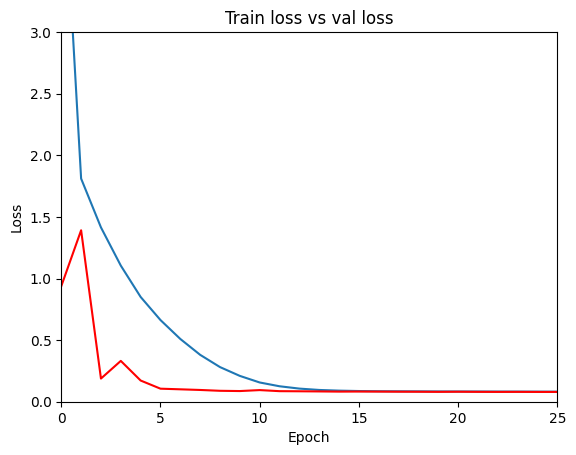

In [330]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'], label="Val Loss", color='red')
    plt.title('Train loss vs val loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xlim([0,25])
    plt.ylim([0,3])
    plt.show()

plot_history(history)

In [325]:
history.history

{'loss': [4.642001152038574,
  1.8111002445220947,
  1.4147896766662598,
  1.1047800779342651,
  0.8503798842430115,
  0.6629039645195007,
  0.509389340877533,
  0.38066136837005615,
  0.28112974762916565,
  0.20962603390216827,
  0.156219020485878,
  0.12545359134674072,
  0.10651141405105591,
  0.09547906368970871,
  0.0899932011961937,
  0.08677084743976593,
  0.0852266252040863,
  0.08468218892812729,
  0.08418603241443634,
  0.08353268355131149,
  0.08317182958126068,
  0.08304078876972198,
  0.08256217837333679,
  0.08234853297472,
  0.08200725167989731,
  0.0815771296620369,
  0.08151588588953018,
  0.08120250701904297,
  0.08115757256746292,
  0.08087936043739319,
  0.0806543231010437,
  0.08065372705459595,
  0.0803728774189949,
  0.08016316592693329,
  0.08014771342277527,
  0.07997648417949677,
  0.07970289885997772,
  0.07966112345457077,
  0.07959029078483582,
  0.07925332337617874,
  0.07936085760593414,
  0.07892375439405441,
  0.0791274905204773,
  0.07899756729602814,


### Predict against X_test

In [353]:
def prediction(X_new, model):
    
    # year=2023,
    # property_type='F',
    # property_age='O',
    # ownership='L',
    # lat=51.491539,
    # lon=0.026218,
    # sin_time=0.5,
    # cos_time=0.85)
    """
    takes new X, processes them and predicts
    """
    #y_new=pd.DataFrame(locals(),index=[0])
    #print(f"✅ new data loaded in df with shape {X_new.shape}")

    # load preprocessor
    # preprocessor=pickle.load(open("models/preprocessor_latlon.pkl","rb"))
    # X_new_processed=preprocessor.transform(X_new)
    # print(f"✅ new data processed with shape {X_new_processed.shape}")

    # predict
    X_new_processed=X_new
    ypred=model.predict(X_new_processed)
    print("✅ model predicted")

    # reverse log price to actual price
    prediction=np.exp(ypred).astype(int)
    print(f" Your predicted price for the property is: {prediction}")
    return prediction

In [ ]:
prediction=prediction(X_new=X_test, model=model_2)

2798/2798 [==============================] - 5s 2ms/step
✅ model predicted
 Your predicted price for the property is: [[260125]
 [611356]
 [434385]
 ...
 [272523]
 [858672]
 [425119]]


### Plot predictions (of x-test) against actual y-test

#### Based on first DNN model

In [201]:
y_test_exp=np.exp(y_test).astype(int)
y_test_exp

price
441438    273530
1676466   984999
916583    295424
170019    780000
1931024   430000
...          ...
1442234   949999
423474    249950
1812138   240000
1949831  1699999
635164    370000

[89506 rows x 1 columns]

In [213]:
# Calculating residuals
comparison=y_test_exp
comparison['prediction']=prediction
comparison['residuals']=comparison['prediction']-comparison['price']

#comparison.set_option('display.float_format', lambda x: f'{x:,.3f}')
comparison.style.format(precision=3, thousands=".")
comparison
# could show all prop where pred is more than 20 pct off real price
comparison[(comparison['residuals']/comparison['price'])>0.25]
comparison.sort_values('residuals')

price  prediction     diff  residuals
53553    3399999      390493 -3009506   -3009506
756038   3299999      352419 -2947580   -2947580
737403   3374999      441837 -2933162   -2933162
2088545  3460000      600893 -2859107   -2859107
2097119  3479999      664365 -2815634   -2815634
...          ...         ...      ...        ...
1328559   324999     1444386  1119387    1119387
1840202   550000     1674103  1124103    1124103
1491160   299999     1515703  1215704    1215704
1136653   234999     1562324  1327325    1327325
1288310   211113     1580936  1369823    1369823

[89506 rows x 4 columns]

In [214]:
comparison.describe()

price    prediction          diff     residuals
count  8.950600e+04  8.950600e+04  8.950600e+04  8.950600e+04
mean   4.796519e+05  4.437218e+05 -3.593007e+04 -3.593007e+04
std    3.674476e+05  2.197757e+05  2.630187e+05  2.630187e+05
min    2.000000e+05  2.156640e+05 -3.009506e+06 -3.009506e+06
25%    2.609990e+05  2.923492e+05 -7.406650e+04 -7.406650e+04
50%    3.650000e+05  3.718340e+05  1.547100e+04  1.547100e+04
75%    5.434840e+05  5.050912e+05  6.645400e+04  6.645400e+04
max    3.490000e+06  1.994738e+06  1.369823e+06  1.369823e+06

(array([   91.,   400.,  1391., 18160., 69238.,   226.]),
 array([-3009506.        , -2279617.83333333, -1549729.66666667,
         -819841.5       ,   -89953.33333333,   639934.83333333,
         1369823.        ]),
 <BarContainer object of 6 artists>)

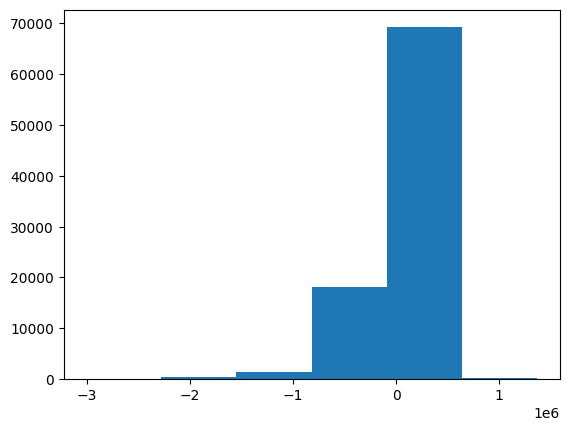

In [215]:
plt.hist(x=comparison['residuals'],label='distribution of residuals', bins=6)
# left skew indicates big outliers where price prediction is too low (could be solved by excluding properties above 2ml? 
# otherwise tendence is slight overprediction (median)

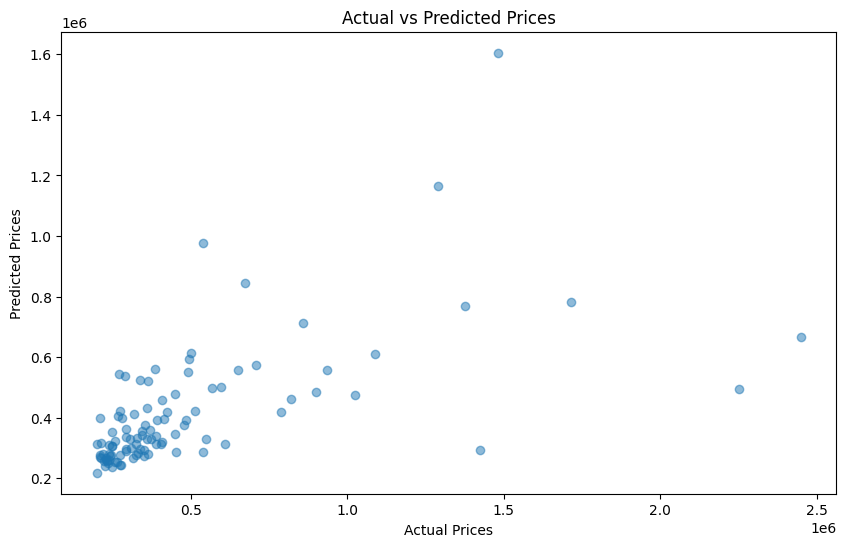

In [109]:

def plot_predictions(y_test: np.ndarray, y_pred: np.ndarray):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs Predicted Prices')
    #plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.show()

plot_predictions(y_test_exp[:100],prediction[:100])

#### plot predictions of 2nd dnn w excluded price outliers log - BEST

In [362]:
# actual price
y_test=y_test.astype(int)
y_test_exp=np.exp(y_test)
y_test_exp

1765004    442413.392009
1474293    442413.392009
383386     442413.392009
822274     442413.392009
1941589    442413.392009
               ...      
1356992    442413.392009
1272186    442413.392009
1525457    442413.392009
824657     162754.791419
1691042    442413.392009
Name: price, Length: 55819, dtype: float64

In [366]:
y_test.shape

(55819,)

In [ ]:
# vs predicted price
prediction=prediction(X_new=X_test, model=model_2)

1745/1745 [==============================] - 3s 2ms/step
✅ model predicted
 Your predicted price for the property is: [[616162]
 [577979]
 [389520]
 ...
 [607931]
 [480615]
 [714981]]


In [355]:
results_train = model_2.evaluate(X_train, y_train, verbose = 0)
results_test = model_2.evaluate(X_test, y_test, verbose = 0)

loss_train=results_train[0]
loss_test=results_test[0]
print (f"loss from training is {loss_train} vs loss from test data {loss_test}")
print(" if train score is > test score, then model is overfitting. Underfitting if ")

loss from training is 0.07668804377317429 vs loss from test data 0.5198734402656555
 if train score is > test score, then model is overfitting. Underfitting if 


In [357]:
# residuals
comparison=y_test_exp
comparison['prediction']=prediction[0]
comparison

1765004       442413.392009
1474293       442413.392009
383386        442413.392009
822274        442413.392009
1941589       442413.392009
                  ...      
1272186       442413.392009
1525457       442413.392009
824657        162754.791419
1691042       442413.392009
prediction         [616162]
Name: price, Length: 55820, dtype: object

In [360]:
prediction

array([[616162],
       [577979],
       [389520],
       ...,
       [607931],
       [480615],
       [714981]])

In [ ]:
comparison['residuals']=comparison['prediction']-comparison['price']
comparison

KeyError: 'price'

In [ ]:
plot_predictions(y_test_exp[:100],prediction[:100])

### visualising feature target relationships

In [216]:
# plot the gridplot that shows relationship of price vs each feature
import seaborn as sns

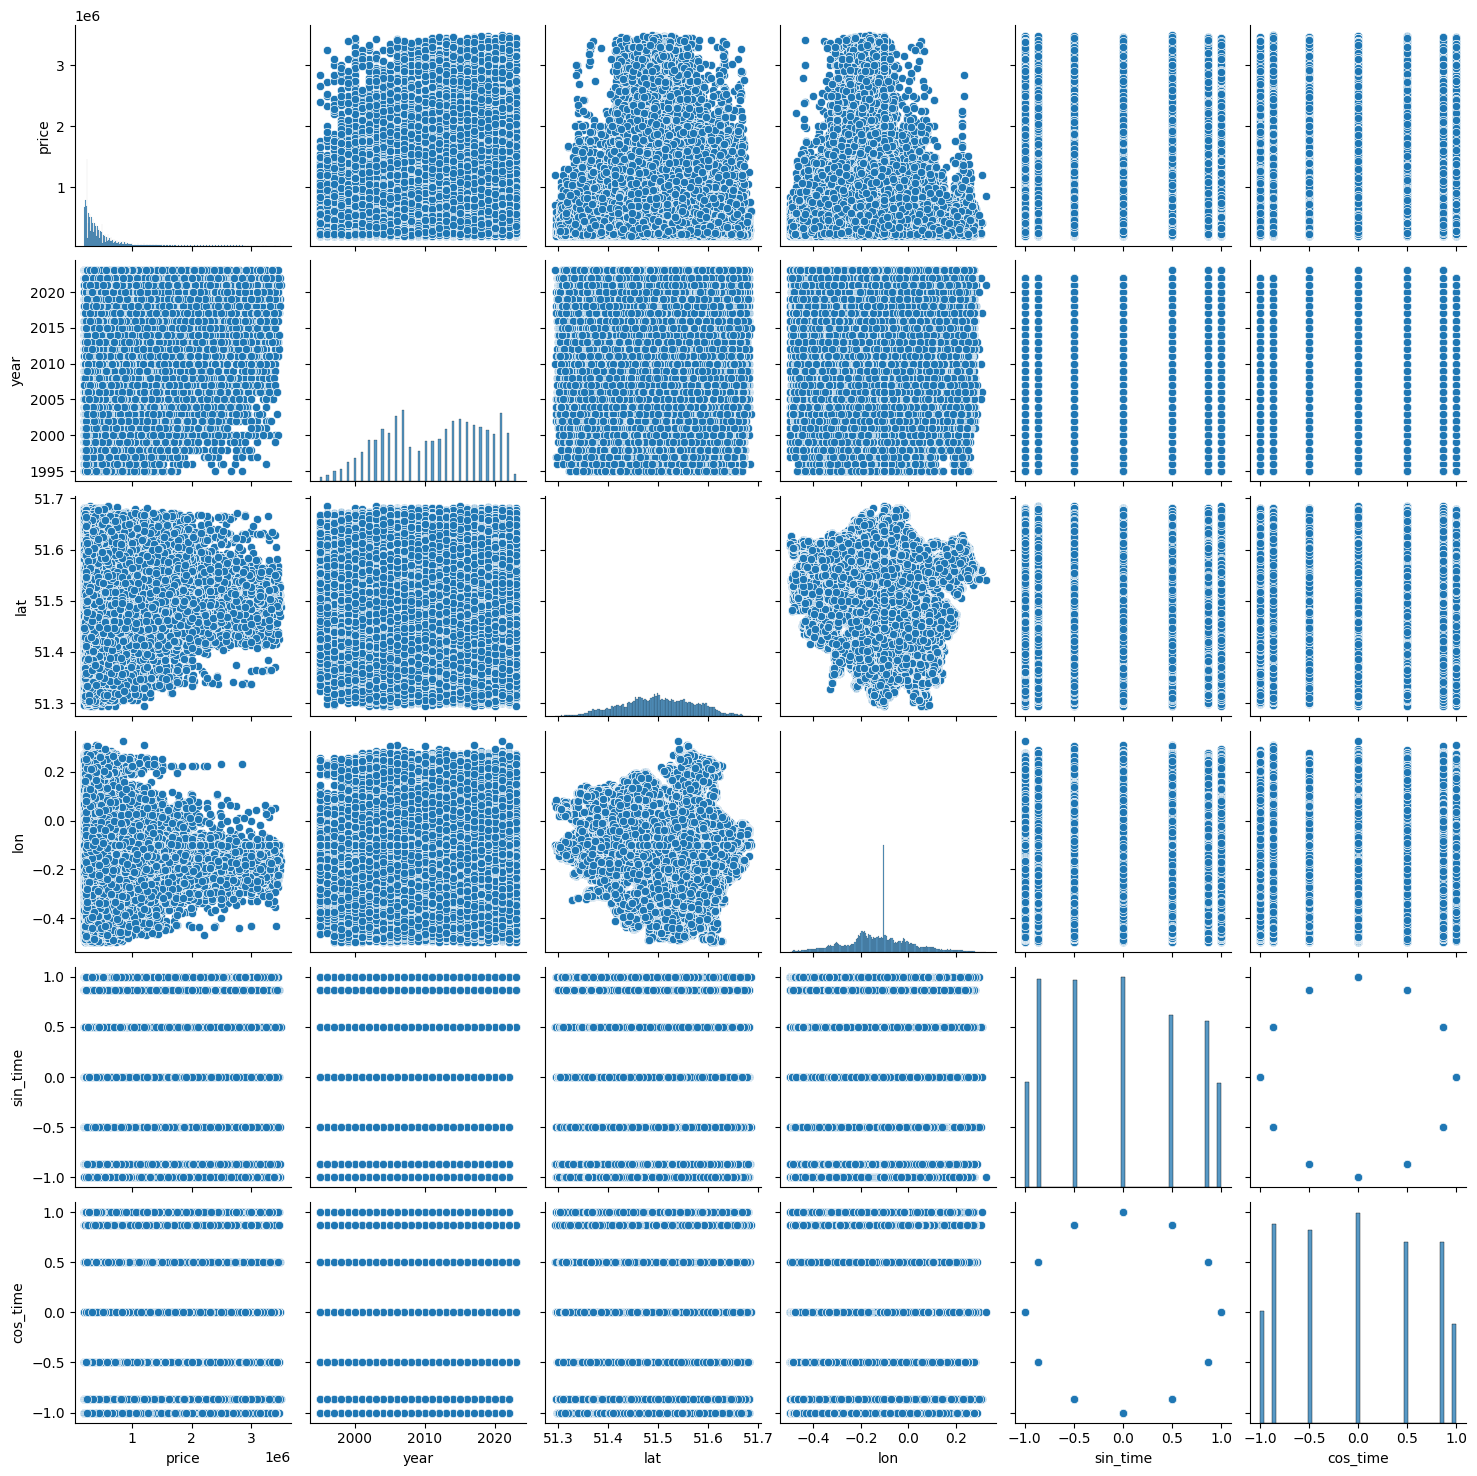

In [218]:
sns.pairplot(data_clean)
plt.show()

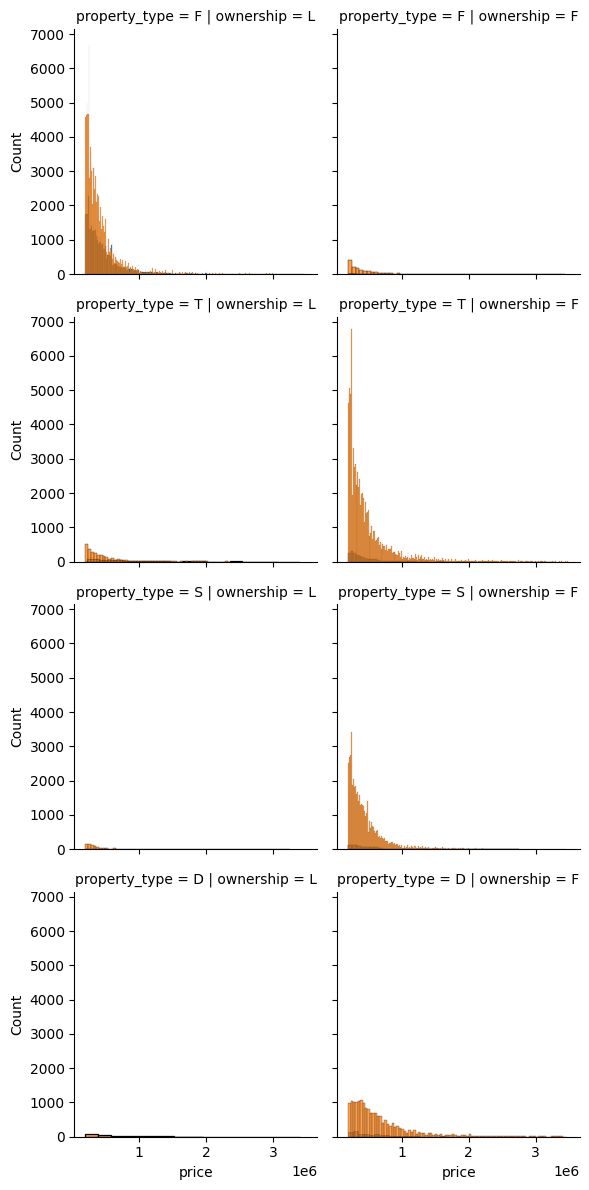

In [226]:
g=sns.FacetGrid(data=data_clean, col='ownership', row='property_type', hue='property_age')
g.map(sns.histplot,'price')

<Axes: xlabel='property_type', ylabel='price'>

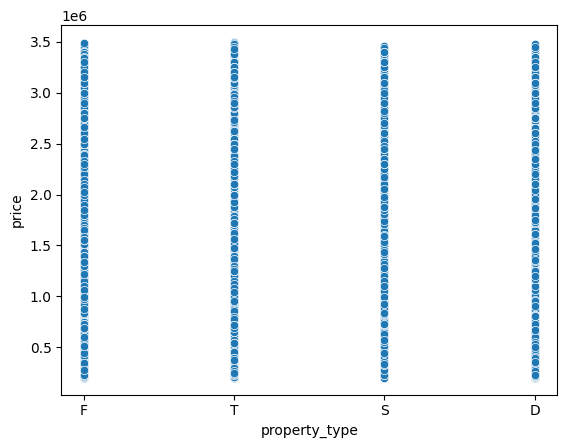

In [229]:
# plot price vs ownership
sns.scatterplot(x=data_clean['property_type'], y=data_clean['price'])

### Try ML model - SGD Regressor

In [ ]:
from sklearn.linear_model import SGDRegressor, LinearRegression


# from sklearn.compose import make_column_selector
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 

from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV #, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

#### First try w existing data

In [254]:
# SGD with linear regression model, instantiate model
#baseline model
baseline = SGDRegressor() 

# crossvalidate baseline model
cv_score=cross_validate(baseline,X_train,y_train,cv=5, scoring=['neg_mean_squared_error','neg_mean_absolute_error'])
cv_score['test_neg_mean_squared_error'].mean(), cv_score['test_neg_mean_absolute_error'].mean()
# solver is SGD - but is classed as a special linear regression model w solver sgd

(-0.2236163749827937, -0.3599280484570142)

In [255]:
sgd = SGDRegressor(loss='huber',early_stopping=True,n_iter_no_change=15) 
# we make scoring neg. as we want to min. these values
cv_score=cross_validate(sgd,X_train,y_train,cv=5, scoring=['neg_mean_squared_error','neg_mean_absolute_error'])
cv_score['test_neg_mean_squared_error'].mean(), cv_score['test_neg_mean_absolute_error'].mean()

(-0.2365856556864757, -0.353307248079801)

In [259]:
warnings.filterwarnings('ignore')
# gridsearch
# Hyperparameter Grid,input as many hyperparameters and values as you want
grid = {
    'alpha': [0.001, 0.01, 0.1, 1], 
    'penalty':['l1','l2','elasticnet'],
    'l1_ratio': [0.2, 0.5, 0.8,1],
    'loss':['squared_error','epsilon_insensitive2','huber'],
    'epsilon':[0.05,0.1,0.3],
    'n_iter_no_change':[5,10,10]
}

# Instantiate Grid Search and calculate the test score that you want (defined in scoring=)
search = GridSearchCV(
    sgd,
    grid, 
    refit='neg_mean_squared_error',
    scoring =['neg_mean_squared_error'],
    cv = 5,
    verbose = 3, # optional but will give descriptive text
    n_jobs=-1 # parallelize computation, -1 means all your cpu is used
) 

# Fit data to Grid Search
search.fit(X_train, y_train)
print(search.best_score_)

# Best Params that achieve the above test score
print(search.best_params_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 1/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.222) total time=   1.0s
[CV 3/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.223) total time=   0.5s
[CV 5/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.223) total time=   0.4s
[CV 4/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.224) total time=   0.6s
[CV 3/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.224) total time=   1.0s
[CV 2/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.225) total time=   0.7s
[CV 5/5] END

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 3/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.224) total time=   1.0s
[CV 1/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.222) total time=   0.5s
[CV 4/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.224) total time=   0.4s
[CV 3/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.224) total time=   0.6s
[CV 2/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.225) total time=   1.0s
[CV 1/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.222) total time=   0.7s
[CV 4/5] END

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

 alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.224) total time=   0.7s
[CV 4/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.224) total time=   0.8s
[CV 3/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.224) total time=   0.9s
[CV 2/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.225) total time=   0.7s
[CV 1/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.222) total time=   0.9s
[CV 5/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.223) total time=   1.0s
[CV 

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 4/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.224) total time=   1.0s
[CV 2/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.225) total time=   0.5s
[CV 1/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.222) total time=   0.5s
[CV 5/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.223) total time=   0.6s
[CV 4/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.224) total time=   1.1s
[CV 3/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.224) total time=   0.7s
[CV 

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  0.0s
[CV 2/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=nan) total time

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 2/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.264) total time=   1.8s
[CV 3/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.260) total time=   1.0s
[CV 4/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.261) total time=   1.1s
[CV 5/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.259) total time=   2.6s
[CV 1/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.237) total time=   3.5s
[CV 2/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.242) total time=   2.8s
[CV 3/5] END alpha=0.001, epsilon=0.05, l1_ratio

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 5/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.240) total time=   2.5s
[CV 1/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.235) total time=   5.9s
[CV 4/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.239) total time=   3.7s
[CV 5/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.239) total time=   2.9s
[CV 1/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.234) total time=   6.2s
[CV 2/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.240) total time=   5.0s
[CV 1/5] END alpha=0.001, epsilon=0.05, l

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 2/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.240) total time=   5.6s
[CV 3/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.238) total time=   6.9s
[CV 4/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.237) total time=   6.3s
[CV 5/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.236) total time=   5.3s
[CV 5/5] END alpha=0.001, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.239) total time=   2.5s
[CV 4/5] END alpha=0.001, epsilon=0.05, l1_ratio=1, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.224) total time=   0.7s
[CV 2/5] END alpha=0.001, epsilon=0.05, l1_ratio=1,

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 2/5] END alpha=0.001, epsilon=0.05, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=0.001, epsilon=0.05, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.001, epsilon=0.05, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.001, epsilon=0.05, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.001, epsilon=0.05, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.1s
[CV 5/5] END alpha=0.001, epsilon=0.05, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total t

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 3/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) tota

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


l time=   0.0s
[CV 1/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=huber, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.235) total time=   1.8s
[CV 5/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=huber, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.233) total time=   2.1s
[CV 1/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.244) total time=   0.5s
[CV 2/5] END a

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 3/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_err

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 3/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.224) total time=   0.7s
[CV 1/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.222) total time=   0.8s
[CV 5/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.223) total time=   0.8s
[CV 4/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.224) total time=   1.0s
[CV 3/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.224) total time=   0.7s
[CV 2/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.225) total time=   0.8

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/


[CV 5/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.223) total time=   0.9s
[CV 3/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.234) total time=   1.7s
[CV 1/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.244) total time=   0.5s
[CV 2/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.251) total time=   0.5s
[CV 3/5] END alpha=0.001, epsilo

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.249) total time=   0.5s
[CV 1/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.236) total time=   0.8s
[CV 2/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.242) total time=   0.8s
[CV 3/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.239) total time=   0.8s
[CV 4/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.240) total time=   0.8s
[CV 4/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.238) total time=   1.3s
[CV 5/5] END alpha=0.001, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=e

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 2/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 3/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.224) total time=   0.9s
[CV 2/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.225) total time=   0.7s
[CV 5/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.223) total time=   0.7s
[CV 4/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.224) total time=   0.8s
[CV 3/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.224) total time=   1.0s
[CV 2/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.225) total time=   0.7s
[CV 1/5] END a

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 3/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.224) total time=   0.8s
[CV 2/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.225) total time=   0.5s
[CV 5/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.223) total time=   0.5s
[CV 4/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.224) total time=   0.6s
[CV 3/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.224) total time=   1.2s
[CV 2/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.225) total time=   0.9s
[CV 5/5] END alpha

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 5/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.1s
[CV 5/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.1s
[CV 1/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.001, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) tota

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 3/5] END alpha=0.001, epsilon=0.3, l1_ratio=1, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.224) total time=   0.9s
[CV 3/5] END alpha=0.001, epsilon=0.3, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=0.001, epsilon=0.3, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=0.001, epsilon=0.3, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.001, epsilon=0.3, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.001, epsilon=0.3, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 3/5] END alpha=0.001, epsilon=0.3, l1_ratio=1, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.224) total time=   0.9s
[CV 2/5] END alpha=0.001, epsilon=0.3, l1_ratio=1, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.225) total time=   0.9s
[CV 1/5] END alpha=0.001, epsilon=0.3, l1_ratio=1, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.222) total time=   0.7s
[CV 5/5] END alpha=0.001, epsilon=0.3, l1_ratio=1, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.223) total time=   0.7s
[CV 4/5] END alpha=0.001, epsilon=0.3, l1_ratio=1, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.224) total time=   1.0s
[CV 1/5] END alpha=0.001, epsilon=0.3, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 2/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (tes

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

.05, l1_ratio=0.8, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.229) total time=   0.5s
[CV 4/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.8, loss=squared_error, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.224) total time=   0.4s
[CV 3/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.8, loss=squared_error, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.227) total time=   0.6s
[CV 2/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.8, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.229) total time=   0.9s
[CV 1/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.8, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.222) total time=   0.6s
[CV 4/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.8, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.224) total time=   0.7s
[CV 3/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.8

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 4/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.264) total time=   1.3s
[CV 5/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.263) total time=   1.3s
[CV 1/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.293) total time=   1.3s
[CV 5/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.241) total time=   0.7s
[CV 4/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.264) total time=   1.4s
[CV 3/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.8, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.230) total time=   0.6s
[CV 1/5] END alpha=0.01, epsilon=0.05, 

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 4/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.1s
[CV 4/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.1s
[CV 5/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (tes

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 3/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.276) total time=   1.9s
[CV 4/5] END alpha=0.01, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.296) total time=   1.4s
[CV 2/5] END alpha=0.01, epsilon=0.05, l1_ratio=1, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.225) total time=   0.7s
[CV 5/5] END alpha=0.01, epsilon=0.05, l1_ratio=1, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.223) total time=   0.7s
[CV 4/5] END alpha=0.01, epsilon=0.05, l1_ratio=1, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.228) total time=   1.4s
[CV 3/5] END alpha=0.01, epsilon=0.05, l1_ratio=1, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.227) total time=   1.8s
[CV 2/5] END alpha=0.0

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 4/5] END alpha=0.01, epsilon=0.05, l1_ratio=1, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.224) total time=   0.7s
[CV 3/5] END alpha=0.01, epsilon=0.05, l1_ratio=1, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.227) total time=   1.5s
[CV 2/5] END alpha=0.01, epsilon=0.05, l1_ratio=1, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.229) total time=   1.8s
[CV 1/5] END alpha=0.01, epsilon=0.05, l1_ratio=1, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.222) total time=   0.8s
[CV 5/5] END alpha=0.01, epsilon=0.05, l1_ratio=1, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.223) total time=   0.7s
[CV 4/5] END alpha=0.01, epsilon=0.05, l1_ratio=1, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.228) total time=   1.0s
[CV 4/5] END alpha

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 2/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.239) total time=   0.7s
[CV 3/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.237) total time=   0.6s
[CV 3/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.5, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.230) total time=   0.5s
[CV 2/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.5, loss=squared_error, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.225) total time=   0.4s
[CV 1/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.5, loss=squared_error, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.224) total time=   0.7s
[CV 5/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.5, loss=squared_error, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.224) total time=   0.7s
[CV 4/5] END alpha=0.01, epsilon

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 4/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.263) total time=   1.3s
[CV 5/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.260) total time=   1.4s
[CV 5/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.8, loss=squared_error, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.226) total time=   0.7s
[CV 2/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.8, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.229) total time=   1.0s
[CV 5/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.8, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.227) total time=   0.9s
[CV 4/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.8, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.224) total time=   0.7s
[CV 3/5] END alpha=0.01, epsilon=0.1,

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 3/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total t

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 4/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.01, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s


/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 4/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.224) total time=   0.6s
[CV 2/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.226) total time=   0.8s
[CV 1/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.226) total time=   1.0s
[CV 5/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.227) total time=   0.8s
[CV 4/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.224) total time=   0.7s
[CV 3/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.224) total time=   0.8s
[CV 4/5] END

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 4/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.228) total time=   0.9s
[CV 3/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.224) total time=   0.7s
[CV 2/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.227) total time=   1.0s
[CV 1/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] EN

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


alty=l2; neg_mean_squared_error: (test=-0.222) total time=   0.4s
[CV 2/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.225) total time=   0.4s
[CV 5/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.223) total time=   0.4s
[CV 3/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.225) total time=   0.6s
[CV 1/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.226) total time=   0.9s
[CV 5/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.227) total time=   0.8s
[CV 5/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squar

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 1/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.243) total time=   0.9s
[CV 2/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.248) total time=   0.9s
[CV 3/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.244) total time=   1.0s
[CV 1/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.243) total time=   0.9s
[CV 2/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.248) total time=   0.9s
[CV 3/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.246) total time=   0.9s
[CV 4/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.2, loss=huber, n_iter_no_ch

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 4/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.243) total time=   1.0s
[CV 5/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.241) total time=   1.0s
[CV 1/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.242) total time=   0.9s
[CV 2/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.247) total time=   0.9s
[CV 5/5] END alpha=0.01, epsilon=0.3, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.240) total time=   1.0s
[CV 1/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.228) total time=   0.6s
[CV 2/5] END alpha=0.01, epsilon=0.3, l1_ratio=

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 5/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.1s
[

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


lpha=0.01, epsilon=0.3, l1_ratio=1, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.241) total time=   0.6s
[CV 2/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.248) total time=   0.6s
[CV 3/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.247) total time=   0.6s
[CV 2/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.233) total time=   0.7s
[CV 3/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.232) total time=   0.6s
[CV 4/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.232) total time=   0.7s
[CV 5/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=huber, n_iter_no_change=10

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 1/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.243) total time=   0.9s
[CV 2/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.247) total time=   1.0s
[CV 3/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.246) total time=   0.9s
[CV 1/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.270) total time=   0.5s
[CV 2/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.271) total time=   0.4s
[CV 3/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.273) total time=   0.6s
[CV 4/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.2, loss=squa

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 2/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.247) total time=   1.0s
[CV 3/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.246) total time=   0.9s
[CV 4/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.244) total time=   1.0s
[CV 2/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.247) total time=   1.0s
[CV 3/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.246) total time=   1.0s
[CV 4/5] END alpha=0.01, epsilon=0.3, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.245) total time=   1.0s
[CV 5/5] END alpha=0.01, epsilon=0.3, l1

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 2/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.5, loss=huber, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.293) total time=   0.7s
[CV 3/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.5, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.273) total time=   0.7s
[CV 4/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.5, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.270) total time=   0.7s
[CV 5/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.5, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.270) total time=   0.7s
[CV 1/5] END alpha=0.1, epsilon=0.05, l1

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 5/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.294) total time=   1.1s
[CV 4/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.272) total time=   1.5s
[CV 3/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.298) total time=   1.2s
[CV 3/5] END alpha=0.1, epsilon=0.05, l1_ratio=1, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.271) total time=   0.6s
[CV 2/5] END alpha=0.1, epsilon=0.05, l1_ratio=1, loss=squared_error, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.231) total time=   0.7s
[CV 1/5] END alpha=0.1, epsilon=0.05, l1_ratio=1, loss=squared_error, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.270) total time=   0.5s
[CV 4/5] END alpha=0.1, epsilon=0.05, l1_rati

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 2/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.297) total time=   1.0s
[CV 4/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.296) total time=   1.1s
[CV 3/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.273) total time=   1.0s
[CV 1/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.293) total time=   1.1s
[CV 4/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.296) total time=   1.2s
[CV 4/5] END alpha=0.1, epsilon=0.05, l1_ratio=1, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.270) total time=   0.5s
[CV 3/5] END alpha=0.1, epsilon=0.05, l1_ratio=1, loss=

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 5/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=0.1, epsilon=0.05, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total t

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 4/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s


/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


l1_ratio=0.2, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.257) total time=   0.7s
[CV 4/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.296) total time=   0.9s
[CV 5/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.294) total time=   1.2s
[CV 1/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.257) total time=   1.5s
[CV 2/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.262) total time=   0.9s
[CV 5/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.294) total time=   1.2s
[CV 1/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: 

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 1/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alp

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 4/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.259) total time=   0.7s
[CV 5/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.257) total time=   0.7s
[CV 1/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.293) total time=   0.8s
[CV 2/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.298) total time=   0.6s
[CV 5/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.258) total time=   1.6s
[CV 1/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.293) total time=   0.9s
[CV 2/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.8, loss=huber,

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 4/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.8, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.272) total time=   0.7s
[CV 2/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.8, loss=squared_error, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.231) total time=   0.8s
[CV 1/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.8, loss=squared_error, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.262) total time=   0.5s
[CV 5/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.8, loss=squared_error, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.261) total time=   0.5s
[CV 4/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.8, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.269) total time=   0.9s
[CV 2/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.8, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.230) total time=   1.0s
[CV 5/5] END alpha=0.1

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


d_error: (test=-0.295) total time=   1.2s
[CV 5/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.295) total time=   1.0s
[CV 1/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.257) total time=   1.6s
[CV 5/5] END alpha=0.1, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.294) total time=   1.0s
[CV 4/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.270) total time=   0.8s
[CV 1/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=squared_error, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.228) total time=   0.8s
[CV 5/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=squared_error, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.228) total time=   0.7s
[CV 5/5] END alph

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 5/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


e=10, penalty=l1; neg_mean_squared_error: (test=-0.298) total time=   1.4s
[CV 5/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.295) total time=   1.2s
[CV 1/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.293) total time=   1.3s
[CV 2/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.298) total time=   1.0s
[CV 3/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.298) total time=   0.9s
[CV 1/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.294) total time=   0.9s
[CV 4/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.296) total time=   

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 2/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=huber, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.293) total time=   0.5s
[CV 5/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.258) total time=   0.7s
[CV 1/5] END alpha=0.1, epsilon=0.1, l1_ratio=1, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.293) total time=   0.7s
[CV 2/5] END alpha=0.1, epsilon=0.1, l1_ratio

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

ilon=0.3, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.228) total time=   1.5s
[CV 5/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.240) total time=   1.4s
[CV 1/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.2, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.259) total time=   1.1s
[CV 2/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.2, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.263) total time=   1.0s
[CV 3/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.2, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.260) total time=   1.0s
[CV 4/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.2, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.260) total time=   1.0s
[CV 2/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.2, loss=h

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 1/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.228) total time=   1.5s
[CV 5/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.228) total time=   1.0s
[CV 4/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.253) total time=   1.9s
[CV 5/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.244) total time=   0.7s
[CV 2/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.281) total time=   1.1s
[CV 3/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.279) total time=   0.5s
[CV 5/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.293) total time=   1.3s
[CV 1/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.241) total time=   1.6s
[CV 2/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.244) total time=   1.4s
[CV 3/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalt

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 5/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.297) total time=   0.8s
[CV 3/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.297) total time=   0.8s
[CV 4/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.276) total time=   1.0s
[CV 5/5] END alpha=0.1, e

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 5/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.242) total time=   1.0s
[CV 1/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.275) total time=   1.2s
[CV 2/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.280) total time=   1.9s
[CV 5/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.241) total time=   1.6s
[CV 1/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.276) total time=   1.2s
[CV 2/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.280) total time=   1.2s
[CV 3/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.5,

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 3/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.244) total time=   1.5s
[CV 2/5] END alpha=0.1, epsilon=0.3, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.297) total time=   1.3s
[CV 1/5] END alpha=0.1, epsilon=0.3, l1_ratio=1, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.269) total time=   0.7s
[CV 4/5] END alpha=0.1, epsilon=0.3, l1_ratio=1, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.270) total time=   0.6s
[CV 3/5] END alpha=0.1, epsilon=0.3, l1_ratio=1, loss=squared_error, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.229) total time=   0.7s
[CV 2/5] END alpha=0.1, epsilon=0.3, l1_ratio=1, loss=squared_error, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.272) total time=   0.5s
[CV 5/5] END alpha=0.1, epsilon=0.3, l1_ratio=

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 2/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=huber, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.294) total time=   0.8s
[CV 1/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.290) total time=   0.7s
[CV 1/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.293) total time=   0.8s
[CV 2/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.298) total time=   1.1s
[CV 3/5] END alpha=1, epsilon=0.05, 

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 4/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.296) total time=   1.2s
[CV 5/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.294) total time=   1.4s
[CV 1/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.290) total time=   1.2s
[CV 2/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.294) total time=   1.1s
[CV 1/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.294) total time=   3.0s
[CV 2/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.298) total time=   1.5s
[CV 3/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penal

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 1/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.284) total time=   0.5s
[CV 4/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.285) total time=   0.5s
[CV 3/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.287) total time=   0.8s
[CV 2/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.261) total time=   1.5s
[CV 1/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.284) total time=   0.8s
[CV 4/5] END alpha=1, epsilon=0.05, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.285) total time=   0.9s
[CV 3/5] E

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 2/5] END alpha=1, epsilon=0.05, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.295) total time=   1.5s
[CV 3/5] END alpha=1, epsilon=0.05, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.295) total time=   0.9s
[CV 1/5] END alpha=1, epsilon=0.05, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.290) total time=   1.0s
[CV 2/5] END alpha=1, epsilon=0.05, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.295) total time=   1.0s
[CV 3/5] END alpha=1, epsilon=0.05, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.294) total time=   1.0s
[CV 4/5] END alpha=1, epsilon=0.05, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.293) total time=   0.9s
[CV 2/5] END alpha=1, epsilon=0.05, l1_ratio=0.8, loss=squared_error, n_iter_no_change=5

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 4/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=1,

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.295) total time=   0.7s
[CV 4/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.293) total time=   0.7s
[CV 3/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.298) total time=   1.2s
[CV 4/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.295) total time=   1.4s
[CV 5/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.294) total time=   1.5s
[CV 1/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.290) total time=   1.0s
[CV 3/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.294) total time=   1.0s
[CV 4/5] EN

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 1/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.1s
[CV 2/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.291) total time=   0.7s
[CV 1/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.293) total time=   0.7s
[CV 2/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.298) total time=   0.8s
[CV 3/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.298) total time=   0.9s
[CV 2/5] END alpha=1, epsilon=0.05, l1_r

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 5/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=huber, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.294) total time=   0.8s
[CV 1/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.294) total time=   1.2s
[CV 2/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.298) total time=   1.1s
[CV 3/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.298) total time=   1.6s
[CV 4/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.296) total time=   1.3s
[CV 2/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.298) total time=   1.3s
[CV 3/5] END alpha=1, epsilon=0.05, l1_ratio=1, loss=huber, n

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


neg_mean_squared_error: (test=-0.287) total time=   0.8s
[CV 1/5] END alpha=1, epsilon=0.1, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.284) total time=   0.8s
[CV 5/5] END alpha=1, epsilon=0.1, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.284) total time=   0.9s
[CV 4/5] END alpha=1, epsilon=0.1, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.259) total time=   1.8s
[CV 3/5] END alpha=1, epsilon=0.1, l1_ratio=0.2, loss=squared_error, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.287) total time=   1.0s
[CV 1/5] END alpha=1, epsilon=0.1, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=1, epsilon=0.1, l1_ratio=0.2, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 4/5] END alpha=1, epsilon=0.1, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.289) total time=   1.8s
[CV 3/5] END alpha=1, epsilon=0.1, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.298) total time=   1.3s
[CV 2/5] END alpha=1, epsilon=0.1, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.298) total time=   1.1s
[CV 1/5] END alpha=1, epsilon=0.1, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.287) total time=   1.8s
[CV 5/5] END alpha=1, epsilon=0.1, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.288) total time=   1.2s
[CV 3/5] END alpha=1, epsilon=0.1, l1_ratio=0.2, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.298) total time=   1.0s
[CV 2/5] END alpha=1, epsilon=0.1, l1_ratio=0.5, loss=squared_error, n_iter_no

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

, epsilon=0.1, l1_ratio=0.5, loss=huber, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=-0.296) total time=   0.9s
[CV 4/5] END alpha=1, epsilon=0.1, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.296) total time=   1.0s
[CV 3/5] END alpha=1, epsilon=0.1, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.291) total time=   3.3s
[CV 2/5] END alpha=1, epsilon=0.1, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.298) total time=   2.8s
[CV 1/5] END alpha=1, epsilon=0.1, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.293) total time=   1.2s
[CV 4/5] END alpha=1, epsilon=0.1, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=-0.296) total time=   1.3s
[CV 3/5] END alpha=1, epsilon=0.1, l1_ratio=0.5, loss=huber, n_iter_no_change=10, penalty=l2; neg_m

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 2/5] END alpha=1, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=1, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=1, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=1, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=1, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.1s
[CV 3/5] END alpha=1, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 4/5] END alpha=1, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=1, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=1, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=5, penalty=elasticnet; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 2/5] END alpha=1, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 1/5] END alpha=1, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 5/5] END alpha=1, epsilon=0.1, l1_ratio=0.8, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] 

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

[CV 2/5] END alpha=1, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.291) total time=   1.5s
[CV 3/5] END alpha=1, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.292) total time=   1.5s
[CV 4/5] END alpha=1, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.289) total time=   1.4s
[CV 4/5] END alpha=1, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=-0.289) total time=   1.5s
[CV 3/5] END alpha=1, epsilon=0.1, l1_ratio=0.8, loss=huber, n_iter_no_change=10, penalty=elasticnet; neg_mean_squared_error: (test=-0.298) total time=   1.5s
[CV 4/5] END alpha=1, epsilon=0.1, l1_ratio=1, loss=squared_error, n_iter_no_change=5, penalty=l1; neg_mean_squared_error: (test=-0.285) total time=   0.5s
[CV 2/5] END alpha=1, epsilon=0.1, l1_ratio=1, loss=squared_error, n_iter_no_chan

/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/

-0.2234555332210096
{'alpha': 0.001, 'epsilon': 0.3, 'l1_ratio': 0.8, 'loss': 'squared_error', 'n_iter_no_change': 10, 'penalty': 'l2'}


SGDRegressor(alpha=0.001, early_stopping=True, epsilon=0.3, l1_ratio=0.8,
             n_iter_no_change=10)

[CV 4/5] END alpha=1, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l1; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 4/5] END alpha=1, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.1s
[CV 5/5] END alpha=1, epsilon=0.3, l1_ratio=0.5, loss=epsilon_insensitive2, n_iter_no_change=10, penalty=l2; neg_mean_squared_error: (test=nan) total time=   0.0s
[CV 3/5] END alpha=1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.281) total time=   0.7s
[CV 4/5] END alpha=1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.277) total time=   0.7s
[CV 5/5] END alpha=1, epsilon=0.3, l1_ratio=0.5, loss=huber, n_iter_no_change=5, penalty=l2; neg_mean_squared_error: (test=-0.277) total time=   0.7s
[CV 1/5] END alpha=1, epsilon=0.3, l1_ratio=0.5, loss=huber, 

In [260]:
search.best_params_


{'alpha': 0.001,
 'epsilon': 0.3,
 'l1_ratio': 0.8,
 'loss': 'squared_error',
 'n_iter_no_change': 10,
 'penalty': 'l2'}

In [261]:
search.best_score_

-0.2234555332210096

In [262]:
# Best estimator - your model with the best params values
sgd_model=search.best_estimator_
sgd_model

SGDRegressor(alpha=0.001, early_stopping=True, epsilon=0.3, l1_ratio=0.8,
             n_iter_no_change=10)

In [ ]:
# train on full - processed data NOT ONLY ON sample - on best model
sgd_model.fit(X_train_full, y_train_full)

# test on unseen data
model.score(X_test, y_test)

# plot learning curves


# predict 

### Try SARIMAX

#### first need to recreate datetime columns

In [ ]:
data_sar=pd.read_csv('raw_data/london_re_postcodes_latlon_master.zip',
                    dtype={'price': np.int32,'month':np.int16,'year':np.int16},
                    ).sample(300000)

In [290]:
# create datetime col
data_sar['date']=pd.to_datetime({'year'=data_sar['year'],
'month'=data_sar['month'],
'day'=data_sar['day']},
yearfirst=True
)

In [ ]:
# we've already excluded property prices below 200K in the dataset...


#### build SARIMAX model

### Try with linear regression?

#### Second try w only 'recent' data (from 2010)